# SARIMAX

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# for determining (p,q) orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# for ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose
# for determining ARIMA orders
from pmdarima import auto_arima                              

from datetime import datetime
from functools import partial

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [3]:
#Load Data
df=pd.read_csv('train.csv')
df.shape

(3000888, 6)

In [4]:
# Filtering Data based on family to consider 'Grocery I'
df1 = df[df['family'] == 'GROCERY I']

In [5]:
# Viewing the columns
df1.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [6]:
# Converting to date
to_datetime_fmt = partial(pd.to_datetime)

#performing a group by on date and taking the sum of sales
df2 = df1.groupby('date')['sales', 'onpromotion'].sum()
df2=df2.reset_index()

In [7]:
# Viewing the data
df2

,date,sales,onpromotion
0,2013-01-01,700.000,0.0
1,2013-01-02,202020.000,0.0
2,2013-01-03,144878.000,0.0
3,2013-01-04,135754.000,0.0
4,2013-01-05,188356.000,0.0
...,...,...,...
1679,2017-08-11,238221.922,36283.0
1680,2017-08-12,238627.633,36370.0
1681,2017-08-13,258442.452,36490.0
1682,2017-08-14,225355.694,35725.0


In [8]:
# Setting the date as the index
df.set_index('date',inplace=True)

In [9]:
#converting object format to date format
df2['date'] = df2['date'].apply(to_datetime_fmt)

df2.set_index('date',inplace=True)
df2.head()

,sales,onpromotion
date,,
2013-01-01,700.0,0.0
2013-01-02,202020.0,0.0
2013-01-03,144878.0,0.0
2013-01-04,135754.0,0.0
2013-01-05,188356.0,0.0


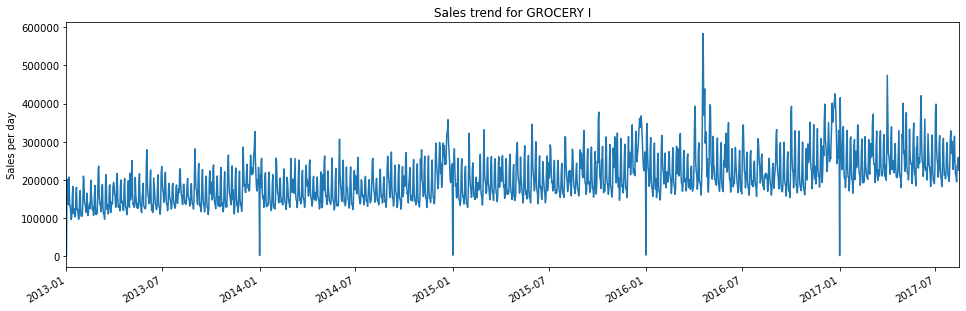

In [10]:
# Visualising the sales trend for Grocery I for each day
title='Sales trend for GROCERY I'
ylabel='Sales per day'
xlabel='' 

ax = df2['sales'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Look at holidays
Using matplotlib to shade holidays in the sales data

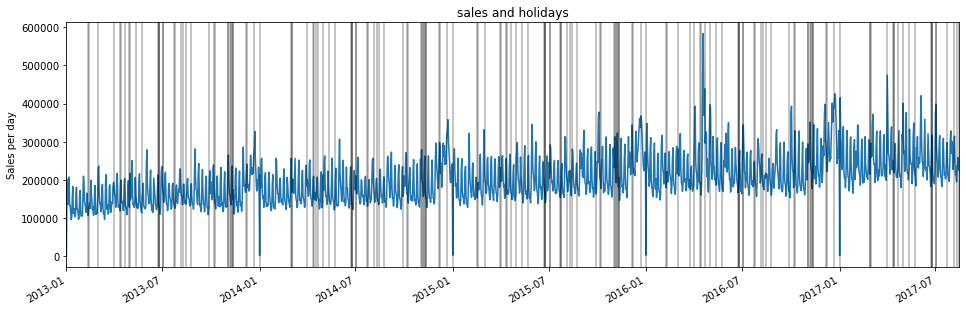

In [217]:
# Visualising the sales trend for Grocery I for each day along with holidays
title='sales and holidays'
ylabel='Sales per day'
xlabel='' 

ax = df3['sales'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df3[df3.type == 'Holiday'].index:       # for days where holidays
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

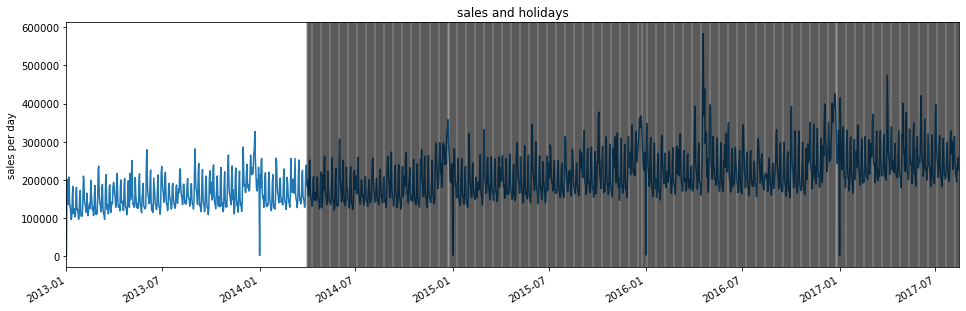

In [255]:
# Visualising the sales trend for Grocery I for each day along with on promtion 
title='sales and holidays'
ylabel='sales per day'
xlabel=''

ax = df2['sales'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df2[df2.onpromotion != 0].index:       # for days where onPromotion
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

From the aove plot, the onpromotion data is missing for more than an year. Thus, we consider Holiday as the exogenous variable

In [286]:
y = df2['sales'].resample('MS').mean()

In [ ]:
df2['date'] = pd.to_datetime(df2['date'])
idx = pd.date_range(start='2013-01-01', end='2017-08-15', freq='D')
df2 = df2.set_index('date').reindex(idx).ffill().reset_index().rename(columns={'index': 'date'})

In [279]:
df2

,date,sales,onpromotion
0,2013-01-01,700.000,0.0
1,2013-01-02,202020.000,0.0
2,2013-01-03,144878.000,0.0
3,2013-01-04,135754.000,0.0
4,2013-01-05,188356.000,0.0
...,...,...,...
1683,2017-08-11,238221.922,36283.0
1684,2017-08-12,238627.633,36370.0
1685,2017-08-13,258442.452,36490.0
1686,2017-08-14,225355.694,35725.0


In [2]:
def mape(Y_actual, y_forecasted):
    val = np.mean(np.abs((Y_actual - y_forecasted)/Y_actual))*100
    return val

## Test for stationarity

In [288]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [289]:
adf_test(df2['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.590914
p-value                    0.005937
# lags used               25.000000
# observations          1662.000000
critical value (1%)       -3.434291
critical value (5%)       -2.863281
critical value (10%)      -2.567697
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders

In [291]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df2['sales'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1688
Model:             SARIMAX(3, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood              -20115.285
Date:                                 Sat, 11 Dec 2021   AIC                          40250.569
Time:                                         21:52:12   BIC                          40304.877
Sample:                                              0   HQIC                         40270.682
                                                - 1688                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7994      0.020     89.274      0.000       1.760       1.839
ar.L2         -1.6857      0.025    -67.914      0.000      -1.734      -1.637
ar.L3          0.5520      0.019     28.766      0.000       0.514       0.590
ma.L1         -2.2119      0.016   -140.061      0.000      -2.243      -2.181
ma.L2          2.1597      0.028     77.062      0.000       2.105       2.215
ma.L3         -0.9261      0.016    -56.349      0.000      -0.958      -0.894
ar.S.L12      -0.4564      0.127     -3.587      0.000      -0.706      -0.207
ma.S.L12       0.1999      0.127      1.577      0.115      -0.049       0.448
ma.S.L24       0.1001      0.045      2.219      0.026       0.012       0.189
sigma2      1.778e+09   5.29e-11   3.36e+19      0.000    1.78e+09    1.78e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.04   Jarque-Bera (JB):              9538.45
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.9e+34. Standard errors may be unstable.
"""


### Split the data into train/test sets


In [14]:
# Set four weeks for testing
train = df2.iloc[:1200]
test = df2.iloc[1200:]

### Fit a SARIMA(3,1,3)(1,0, [1,2], 12) Model

In [297]:
model = SARIMAX(train['sales'],order=(3,1,3),seasonal_order=(1, 0, [1, 2], 12),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   sales   No. Observations:                 1200
Model:             SARIMAX(3, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood              -14248.869
Date:                                 Sat, 11 Dec 2021   AIC                          28517.738
Time:                                         21:58:51   BIC                          28568.630
Sample:                                     01-01-2013   HQIC                         28536.909
                                          - 04-14-2016                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6344      0.646      0.982      0.326      -0.632       1.901
ar.L2         -0.1876      0.545     -0.345      0.730      -1.255       0.880
ar.L3         -0.1314      0.321     -0.409      0.682      -0.761       0.498
ma.L1         -0.9858      0.640     -1.540      0.123      -2.240       0.269
ma.L2         -0.0964      0.767     -0.126      0.900      -1.600       1.407
ma.L3          0.2001      0.205      0.974      0.330      -0.203       0.603
ar.S.L12      -0.7975      0.061    -13.109      0.000      -0.917      -0.678
ma.S.L12       0.4866      0.061      8.000      0.000       0.367       0.606
ma.S.L24      -0.3843      0.027    -13.976      0.000      -0.438      -0.330
sigma2      1.423e+09   3.38e-09    4.2e+17      0.000    1.42e+09    1.42e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1349.96
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.69e+33. Standard errors may be unstable.
"""

In [299]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

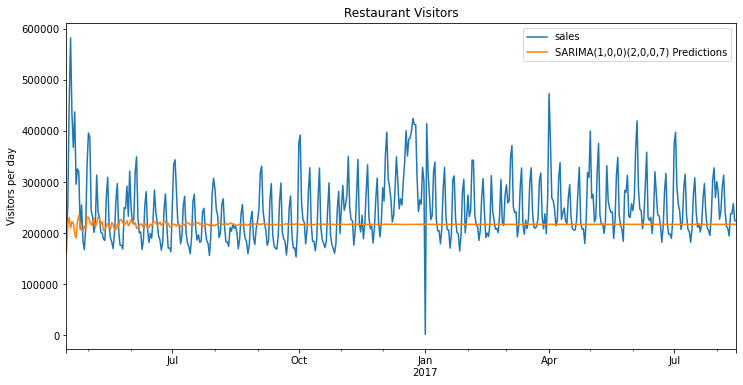

In [302]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### Evaluate the Model

In [15]:
error1 = mape(test['sales'], predictions)

print(' MAPE for SARIMAX: ', error1)

 MAPE for SARIMAX: 67.34


### Now adding the exog variable - Holidays

In [305]:
model = SARIMAX(train['sales'],exog=train['onpromotion'],order=(3,1,3),seasonal_order=(1, 0, [1, 2], 12),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   sales   No. Observations:                 1200
Model:             SARIMAX(3, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood              -13960.649
Date:                                 Sat, 11 Dec 2021   AIC                          27943.297
Time:                                         22:00:32   BIC                          27999.279
Sample:                                     01-01-2013   HQIC                         27964.386
                                          - 04-14-2016                                         
Covariance Type:                                   opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
onpromotion    11.1210      0.179     62.262      0.000      10.771      11.471
ar.L1           1.7311      0.049     34.988      0.000       1.634       1.828
ar.L2          -1.5997      0.061    -26.140      0.000      -1.720      -1.480
ar.L3           0.4839      0.049      9.841      0.000       0.387       0.580
ma.L1          -2.0898      0.038    -55.029      0.000      -2.164      -2.015
ma.L2           2.0134      0.050     39.939      0.000       1.915       2.112
ma.L3          -0.8083      0.034    -23.840      0.000      -0.875      -0.742
ar.S.L12       -0.3367      0.155     -2.179      0.029      -0.640      -0.034
ma.S.L12        0.0292      0.154      0.190      0.850      -0.273       0.331
ma.S.L24        0.1518      0.061      2.502      0.012       0.033       0.271
sigma2       9.774e+08   4.51e-10   2.17e+18      0.000    9.77e+08    9.77e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              1833.41
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.29e+33. Standard errors may be unstable.
"""

In [307]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['onpromotion']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

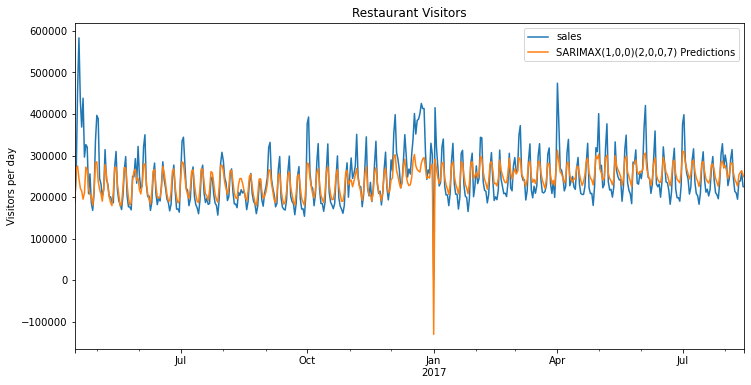

In [309]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [36]:
# Evaluating the model
error2 = mape(test['sales'], predictions)

print(' MAPE for SARIMAX: ', error2)
print(' MAPE for SARIMAX: 24.12')

 MAPE for SARIMAX: 24.12
